In [41]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression


In [42]:
df = pd.read_csv('csv/helpdesk_customer_tickets_translated.csv')
df.sample(3)

,id,subject,body,answer,type,queue,priority,language,business_type,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,subject_translated,body_translated
462,2780960502938,Rechnung Differenz Problem,"Sehr geehrtes IT-Serviceteam, ich schreibe, um...","Sehr geehrte/r <name>,\n\nvielen Dank, dass Si...",Incident,Billing and Payments,medium,de,IT Services,Billing Issue,Account Assistance,Payment Processing,Problem Resolution,Customer Service,NaN,NaN,NaN,NaN,invoice difference problem,"Dear IT Services Team, I am writing to report ..."
150,1538646422880,Anfrage zum Austausch wegen Verbindungsproblemen,"Sehr geehrtes Kundenserviceteam,\n\nich hoffe,...",Betreff: Re: Anfrage zum Austausch wegen Verbi...,Change,Returns and Exchanges,low,de,Tech Online Store,Returns and Exchanges,Product Support,Technical Support,Account Assistance,NaN,NaN,NaN,NaN,NaN,Request for exchange due to connection problems,"Dear Customer Service Team,\n\nI hope this mes..."
781,4353477443453,Anfrage zum Kauf,"Sehr geehrtes Kundenserviceteam, ich hoffe, di...","Lieber <name>,\n\nvielen Dank, dass Sie sich m...",Request,Customer Service,low,de,Tech Online Store,Sales Inquiry,Billing Issue,Product Support,Order Issue,Payment Processing,Customer Service,Service Notification,Shipment Delay,NaN,purchase request,"Dear Customer Service Team, I hope this messag..."


In [43]:
# rmeove subject and body fields and place subject_translated and body_translated in its place
df.drop(columns=['subject', 'body'], inplace=True)


In [44]:
cols = df.columns.tolist()
cols.insert(1, cols.pop(cols.index("subject_translated")))
cols.insert(2, cols.pop(cols.index("body_translated")))
print(cols)

['id', 'subject_translated', 'body_translated', 'answer', 'type', 'queue', 'priority', 'language', 'business_type', 'tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8', 'tag_9']


In [45]:
df = df[cols]
df.sample(3)

,id,subject_translated,body_translated,answer,type,queue,priority,language,business_type,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9
1164,6951187088974,Refund Request Due to Incorrect Billing,"Hello,\n\nI hope this message finds you well. ...",Objet : Re : Demande de remboursement en raiso...,Incident,Billing and Payments,high,fr,Tech Online Store,Billing Issue,Refund Request,Customer Service,Payment Processing,NaN,NaN,NaN,NaN,NaN
32,1123904357692,Surface Pro 7 Problem - Screen Flickering,"Dear Tech Online Store Support,\n\nI am writin...","Caro <name>,\n\nObrigado por entrar em contato...",Incident,Technical Support,high,pt,Tech Online Store,Product Support,Technical Support,Warranty Claim,Hardware Failure,System Crash,Problem Resolution,NaN,NaN,NaN
80,1298612785497,Request for Configuration Changes,"Dear IT Support Team, \n\nI hope this email fi...","Dear <name>,\n\nThank you for reaching out to ...",Change,Technical Support,high,en,IT Services,IT Support,Technical Support,Performance Tuning,Technical Guidance,Account Assistance,General Inquiry,NaN,NaN,NaN


In [46]:
df = df.rename(columns={'subject_translated': 'subject', 'body_translated': 'body'})

In [47]:
df.sample(3)

,id,subject,body,answer,type,queue,priority,language,business_type,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9
1305,7938886814464,Urgent Issue: Email Access in Office 365,"Dear Customer Support,\n\nI am writing to info...","Estimado <name>,\n\nGracias por contactar al s...",Problem,Technical Support,high,es,IT Services,Urgent Issue,Login Issue,Technical Support,Product Support,Office 365,Problem Resolution,Service Notification,NaN,NaN
973,5571424323843,Upgrade Zoom request,"Dear Customer Service,\n\nI hope this email fi...","Sehr geehrter <name>,\n\nvielen Dank, dass Sie...",Change,Technical Support,high,de,IT Services,Technical Support,Product Support,Software Bug,Account Assistance,System Maintenance,Service Recovery,Technical Guidance,NaN,NaN
487,2908265618945,Assistance Required for Epson EcoTank ET-4760 ...,"Dear Tech Online Store Support Team, I am expe...","Caro <name>,\n\nObrigado por entrar em contato...",Incident,Product Support,medium,pt,Tech Online Store,Technical Support,Product Support,Problem Resolution,Hardware Failure,Customer Service,Service Recovery,Technical Guidance,NaN,NaN


### **Analysis**
- While the model accuracy and precision comes out to be very good, when testing from user perspective, I find that the output by the model is not as accurate as I'd want 
- Due to keyword importance conflicts, I removed type and queue and just added the processed text (subject and body) as feature for the model
- After analysis, I find that the words present in the tags can also help the model to better classify

In [48]:
# combine all tags to one column, ignore tags with NaN tage 1-9
df['tags'] = df[['tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8', 'tag_9']].apply(lambda x: ' '.join(x.dropna()), axis=1)
df.sample(3)

,id,subject,body,answer,type,queue,priority,language,business_type,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tags
769,4295233202994,Urgent Update Required for Jira Software 8.20,"Dear Customer Support,\n\nI am writing to urge...","Prezado <name>,\n\nObrigado por entrar em cont...",Change,Service Outages and Maintenance,high,pt,IT Services,Technical Support,Service Disruption,Urgent Issue,Software Bug,Problem Resolution,Service Recovery,System Maintenance,NaN,NaN,Technical Support Service Disruption Urgent Is...
1099,6473991468115,Screen Flickering Issue with Dell XPS 13,"Dear Tech Online Store Support,\n\nI am experi...","Dear <name>,\n\nThank you for reaching out. We...",Incident,Technical Support,medium,en,Tech Online Store,Technical Support,Software Bug,Problem Resolution,Product Support,Hardware Failure,Performance Tuning,NaN,NaN,NaN,Technical Support Software Bug Problem Resolut...
721,4088488277132,Request for JavaScript React development services,"Hello Customer Service Team,\n\nI hope this me...","Hallo <name>,\n\nVielen Dank, dass Sie sich mi...",Request,Sales and Pre-Sales,medium,de,Software Development Company,Technical Support,Product Support,Customer Service,Software Bug,Feature Request,General Inquiry,Technical Guidance,Sales Inquiry,NaN,Technical Support Product Support Customer Ser...


In [49]:
df.shape

(1564, 19)

In [50]:
df.drop(['tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8', 'tag_9'], axis=1, inplace=True)

In [51]:
df.sample(5)
df.to_csv('csv/tickets_translated.csv', index=False)

### Tokenize and lemmatize function
NOTE: This has been removed later in order to understand relationships between keywords

In [52]:
import spacy

nlp = spacy.load('en_core_web_sm')

# create function to preprocess text
def preprocess_text(text):
    text = text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').strip()
    # doc = nlp(text)
    # preprocessed_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    # return ' '.join(preprocessed_tokens)
    return text


In [53]:
# preprocess the tags
df['tags'] = df['tags'].apply(preprocess_text)

In [54]:
df.sample(3)

,id,subject,body,answer,type,queue,priority,language,business_type,tags
285,2079257701130,Request for detailed information about React s...,"Dear Customer Service Team,\n\nI hope this mes...","Sehr geehrter <name>,\n\nvielen Dank, dass Sie...",Request,Sales and Pre-Sales,medium,de,Software Development Company,Technical Support Customer Service Sales Inqui...
200,1713188615385,Urgent Resolution Required,"Dear Customer Support Team, \n\nI am writing t...","Dear <name>,\n\nThank you for reaching out and...",Incident,IT Support,high,en,IT Consulting Firm,Urgent Issue IT Support Incident Report Servic...
1254,7554985198494,Ask about professional support,"Hi Support Team,\n\nI need expert guidance in ...","Hola <name>,\n\nAgradecemos que te hayas puest...",Request,Technical Support,medium,es,IT Services,Technical Support IT Support Product Support T...


In [55]:
df.dropna(subset=['subject', 'body'], inplace=True)

df['subject'] = df['subject'].apply(preprocess_text)
df['body'] = df['body'].apply(preprocess_text)

df.sample(3)

,id,subject,body,answer,type,queue,priority,language,business_type,tags
1165,6960674503041,Urgent solution to the wireless printing problem,Problems with the HP DeskJet 3755 printer via ...,"Bitte versuchen Sie, Ihren Drucker erneut mit ...",Request,IT Support,high,de,IT Services,Technical Support Urgent Issue Problem Resolut...
1183,7084866600524,Support Request: AWS resource configuration issue,"Hello IT Services Support Team, I hope this m...","Hallo <name>,\n\nWir schätzen es, dass Sie uns...",Incident,IT Support,medium,de,IT Services,Technical Support Service Disruption Incident ...
1116,6593575187453,Problem with Surface Pro 7,"Dear Tech Online Store Customer Support, I ho...","Caro <name>,\n\nObrigado por entrar em contato...",Incident,Product Support,medium,pt,Tech Online Store,Technical Support Product Support Hardware Fai...


In [56]:
df_synthesized = pd.read_csv('csv/synthesized_tickets.csv')
df_synthesized.sample(3)

,processed_text,subject,body,urgency
768,High-Priority: Payment Gateway Down. The main ...,High-Priority: Payment Gateway Down,"The main network is down, affecting all depart...",urgent
913,Request for Profile Update. This is not critic...,Request for Profile Update,This is not critical and can be resolved later.,not_urgent
1018,Query Regarding Leave Balances. This is not cr...,Query Regarding Leave Balances,This is not critical and can be resolved later.,not_urgent


In [57]:
df['processed_text'] = df['subject'] + '. ' + df['body']

df_en = df.drop(columns=['language'])

In [58]:
df_en = df_en[['processed_text', 'type', 'queue', 'priority']]
df_en.sample(10)


,processed_text,type,queue,priority
71,Issues with AWS Management Service Deployment....,Problem,Technical Support,medium
141,Urgent Attention Required for Jira Software Bu...,Problem,Technical Support,high
783,"Problems with Cisco Router ISR4331. Hi, I am e...",Problem,Technical Support,high
1,Intermittent Cursor Freezing Issue on Dell XPS...,Incident,Product Support,low
554,Urgent: Support needed for data loss recovery ...,Incident,Technical Support,high
1272,"Zoom Update Request. Dear Customer Support, I...",Change,Technical Support,high
970,Urgent support for laptop problems. Dear Tech ...,Request,Product Support,high
1139,Screen flickering issue on Dell XPS 13. Dear C...,Problem,Product Support,high
788,Assistance with AWS Management. Dear Customer ...,Request,Billing and Payments,low
229,Network failure due to a fault in the Cisco ro...,Incident,Technical Support,high


### Data Visualization

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

high_priority = df_en[df_en.priority == 'high']
medium_priority = df_en[df_en.priority == 'medium']
low_priority = df_en[df_en.priority == 'low']

def tfidf_vectorizer(text):
    tdidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
    tdidf_matrix = tdidf_vectorizer.fit_transform(text)
    feature_names = tdidf_vectorizer.get_feature_names_out()
    word_scores = zip(feature_names, tdidf_matrix.sum(axis=0).tolist()[0])

    top_words = sorted(word_scores, key=lambda x: x[1], reverse=True)[:10]
    return top_words

high_priority_top_words = tfidf_vectorizer(high_priority['processed_text'])
medium_priority_top_words = tfidf_vectorizer(medium_priority['processed_text'])
low_priority_top_words = tfidf_vectorizer(low_priority['processed_text'])

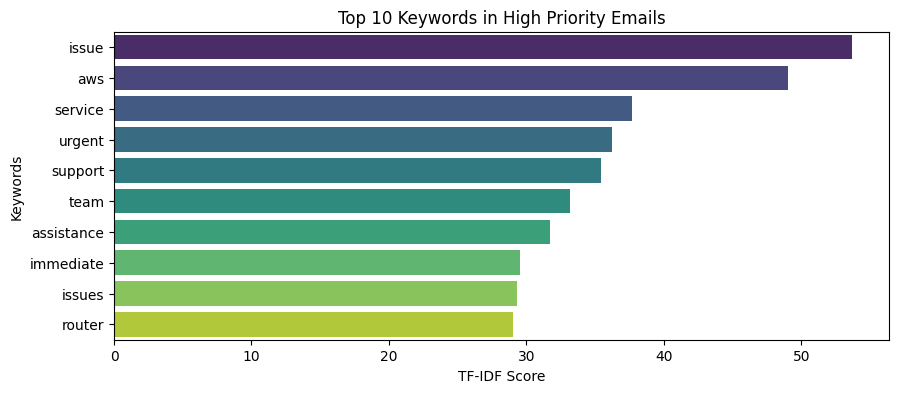

In [60]:
keywords, frequencies = zip(*high_priority_top_words)

plt.figure(figsize=(10, 4))
sns.barplot(x=frequencies, y=keywords, palette='viridis', hue=keywords)
plt.xlabel('TF-IDF Score')
plt.ylabel('Keywords')
plt.title('Top 10 Keywords in High Priority Emails')
plt.show()

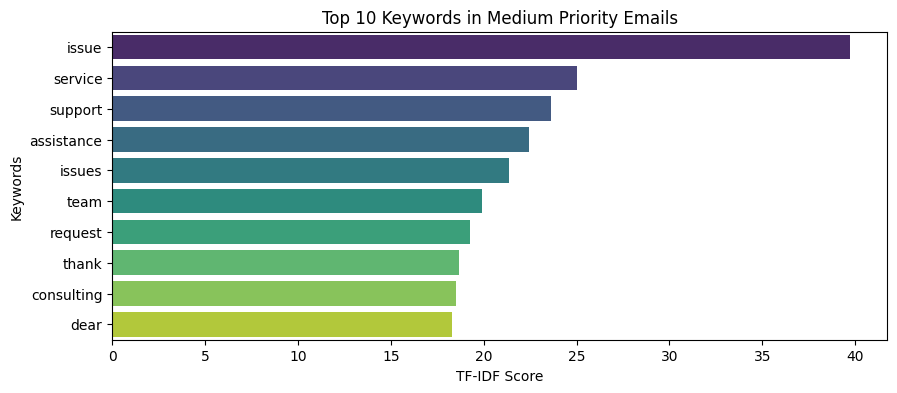

In [61]:
keywords, frequencies = zip(*medium_priority_top_words)

plt.figure(figsize=(10, 4))
sns.barplot(x=frequencies, y=keywords, palette='viridis', hue=keywords)
plt.xlabel('TF-IDF Score')
plt.ylabel('Keywords')
plt.title('Top 10 Keywords in Medium Priority Emails')
plt.show()

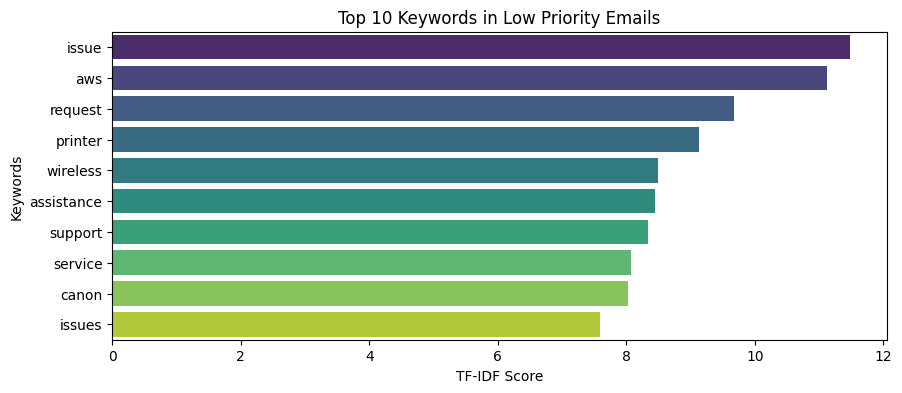

In [62]:
keywords, frequencies = zip(*low_priority_top_words)

plt.figure(figsize=(10, 4))
sns.barplot(x=frequencies, y=keywords, palette='viridis', hue=keywords)
plt.xlabel('TF-IDF Score')
plt.ylabel('Keywords')
plt.title('Top 10 Keywords in Low Priority Emails')
plt.show()

### Model Training - Logistic Regression
**Why?** 
- Good for simple data 
- Fast

**Cons**
- Assumes linear relationship 
- Sensitive to outliers

In [63]:
df_en.shape

(1564, 4)

In [64]:
df_en['urgency'] = df['priority'].apply(lambda x: 'urgent' if x == 'high' else 'not_urgent')

In [65]:
df_en.sample(3)

,processed_text,type,queue,priority,urgency
254,Frequent Disconnect Issues with Cisco Router I...,Problem,Technical Support,high,urgent
1100,Help needed for HP DeskJet 3755 paper jams. De...,Problem,Product Support,medium,not_urgent
1202,Clarification on Service Fee. Dear Customer Su...,Request,Billing and Payments,medium,not_urgent


In [66]:
df_en[df_en.urgency == 'urgent'].shape

(787, 5)

In [67]:
df_en[df_en.urgency == 'not_urgent'].shape

(777, 5)

In [68]:
df_en.to_csv('csv/processed_tickets_en.csv', index=False)

In [69]:
X = df_en[['processed_text']]
y = df_en['urgency']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
# Building the TF-IDF transformer and model pipeline
text_transformer = Pipeline([
    ('tfidf', TfidfVectorizer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('text_tfidf', text_transformer, 'processed_text')
    ],
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

In [71]:
# Train the model
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  not_urgent       0.91      0.92      0.91       156
      urgent       0.92      0.90      0.91       157

    accuracy                           0.91       313
   macro avg       0.91      0.91      0.91       313
weighted avg       0.91      0.91      0.91       313



In [72]:
# Example prediction
example = pd.DataFrame({
    'processed_text': ['I need to know about my order status, urgently.']
})

urgency = pipeline.predict(example)
print(f'Predicted urgency: {urgency[0]}')


Predicted urgency: not_urgent


### Model Training 

In [73]:
from sklearn.svm import SVC

pipeline_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42))
])

In [74]:
pipeline_svm.fit(X_train, y_train)

y_pred_svm = pipeline_svm.predict(X_test)

print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

  not_urgent       1.00      0.99      1.00       156
      urgent       0.99      1.00      1.00       157

    accuracy                           1.00       313
   macro avg       1.00      1.00      1.00       313
weighted avg       1.00      1.00      1.00       313



In [75]:
# Example prediction
example = pd.DataFrame({
    'processed_text': ['Assistance Required. I encountered an issue with my order. I need the item urgently.']
})

urgency = pipeline_svm.predict(example)
print(f'Predicted urgency: {urgency[0]}')

Predicted urgency: urgent
